## Let's create a dataset by downloading images from Bing

### Generate a dataframe from the downloaded images

In [7]:
import os
import pandas as pd

QUERIES = ["cpp", "hs", "py"]
directory = "./raw_data/img/ready"
data = []
label = ""
for file in os.listdir(directory):
    if(file.startswith("cpp")):
        label = "cpp"
    elif(file.startswith("hs")):
        label = "hs"
    elif(file.startswith("py")):
        label = "py"    
    
    data.append([os.path.join(directory, file), label])
dataframe = pd.DataFrame(data, columns=["path", "label"])
print(dataframe)

                                          path label
0     ./raw_data/img/ready\cpp100_tile_1_1.png   cpp
1     ./raw_data/img/ready\cpp100_tile_2_1.png   cpp
2     ./raw_data/img/ready\cpp100_tile_2_2.png   cpp
3     ./raw_data/img/ready\cpp100_tile_3_1.png   cpp
4     ./raw_data/img/ready\cpp100_tile_3_2.png   cpp
...                                        ...   ...
1189     ./raw_data/img/ready\py9_tile_1_1.png    py
1190     ./raw_data/img/ready\py9_tile_2_1.png    py
1191     ./raw_data/img/ready\py9_tile_2_2.png    py
1192     ./raw_data/img/ready\py9_tile_3_1.png    py
1193     ./raw_data/img/ready\py9_tile_3_2.png    py

[1194 rows x 2 columns]


### Show some images of the dataset

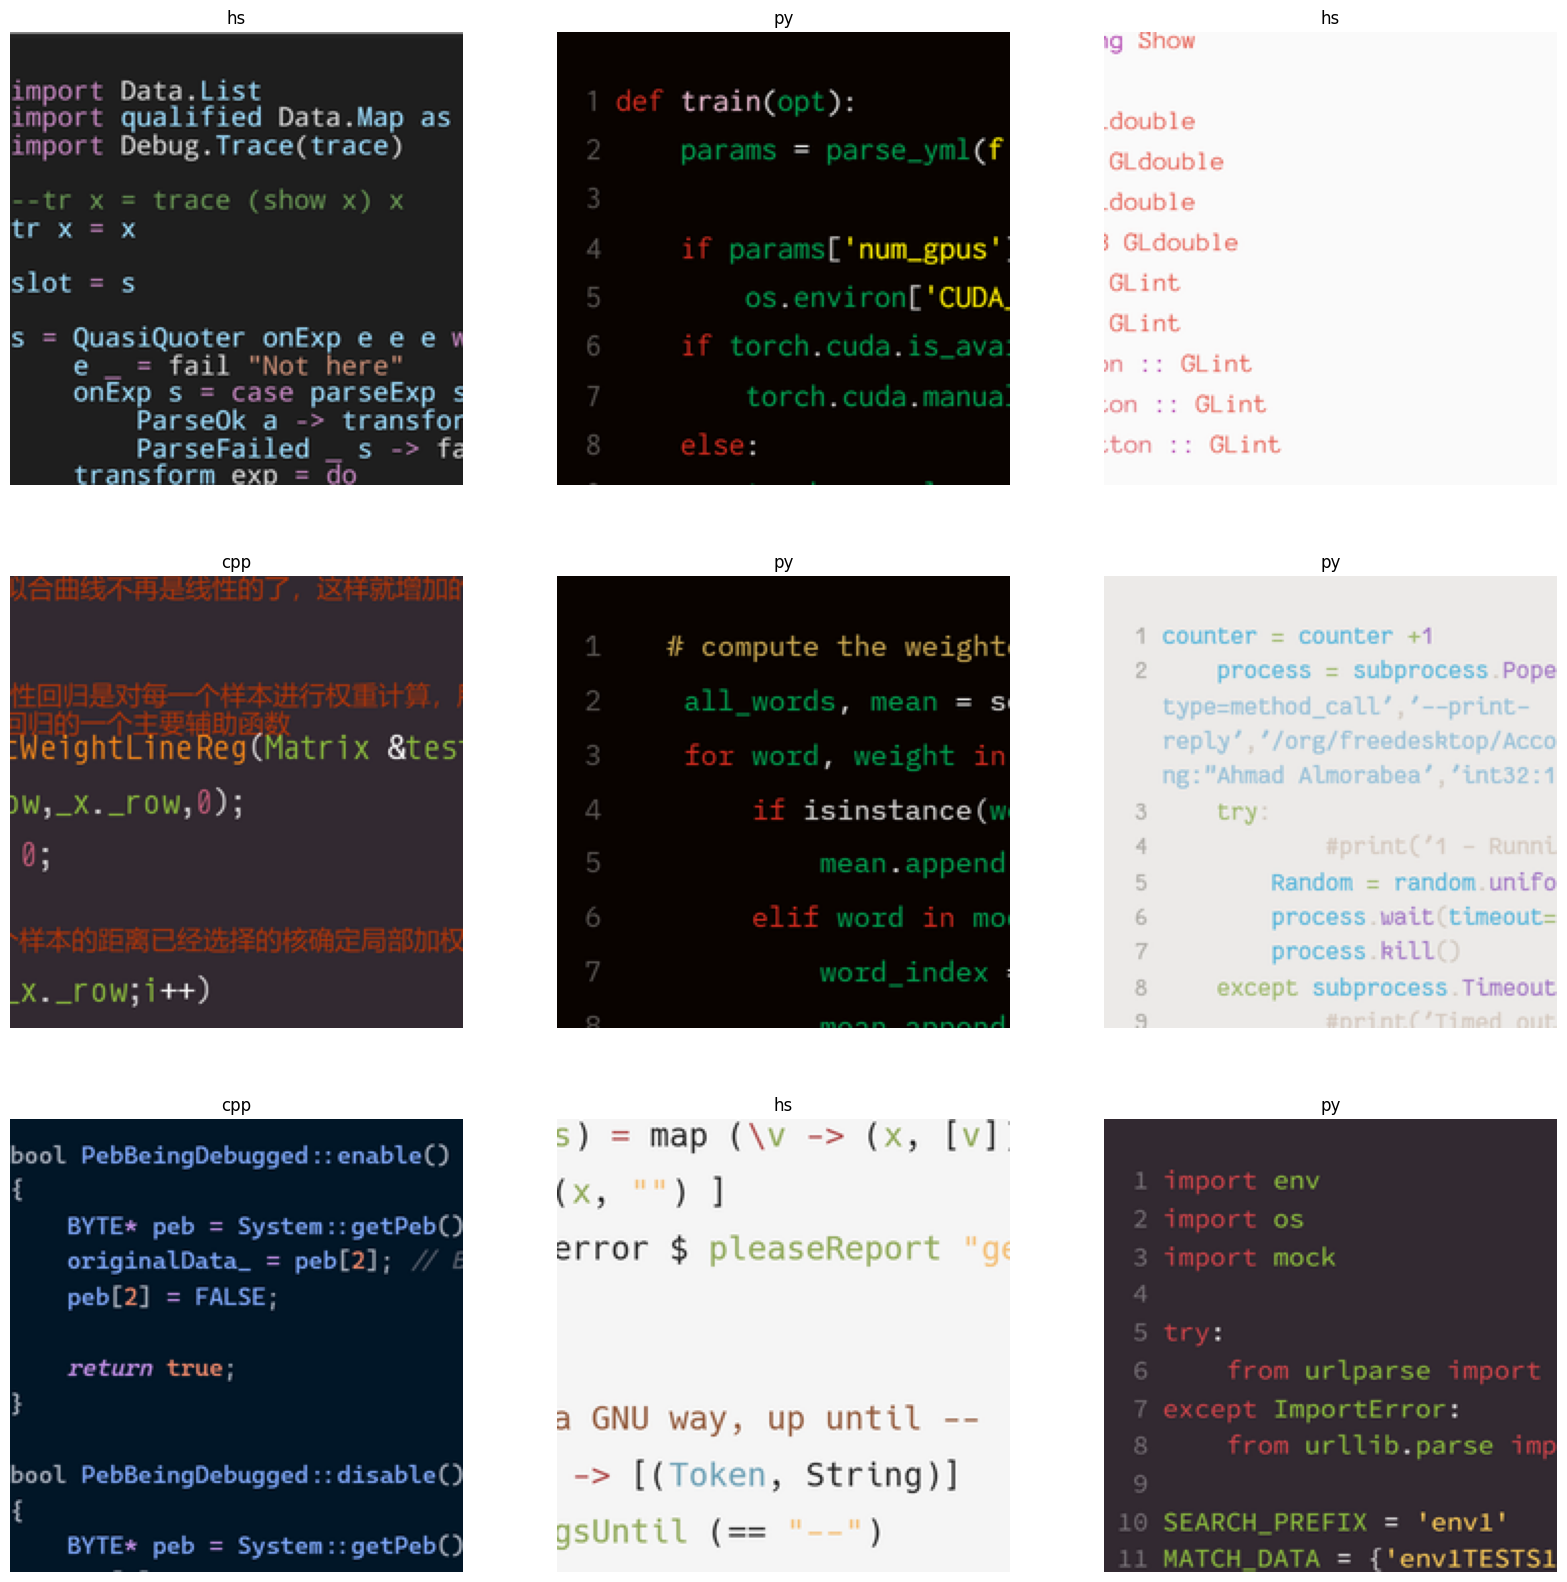

In [8]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image
 
plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in dataframe.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

## Fetch MobileNetV2 model

In [9]:
import tensorflow
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False # We don't want to include the fully-connected layers
)

In [10]:
# You can see the list of layers of this model
base_model.layers

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D
)

def get_model():
    # We want to add layers on top of the base (here MobileNetV2) model
    layers = base_model.output

    # We need to flatten
    layers = Flatten()(layers)
    #layers = GlobalAveragePooling2D()(layers)


     # Add dense layers with batch normalization and dropout
    layer1 = Dense(128, activation='relu')(layers)
    layer1_do = Dropout(0.5)(layer1)

    # We must add an output layer
    output = Dense(len(QUERIES), activation='softmax')(layer1_do) # final layer with softmax activation

    model = Model(inputs=base_model.input, outputs=output)

    #Freeze the base model
    for layer in base_model.layers:
      layer.trainable = True
    # for layer in base_model.layers[-123:]:
    #     layer.trainable = True
    # Dégeler quelques couches du modèle de base et continuer l'entraînement
    # for layer in base_model.layers[-10:]:
    #   layer.trainable = True
    
    model.compile(
      optimizer = Adam(learning_rate=0.0001),
      # Sparse categorical crossentropy is used when we have target class as integers
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

In [12]:
get_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

## Cross validate model

In [13]:
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras import Sequential

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

In [14]:
def open_images(paths):
    images = []
    for path in paths:
        with PIL.Image.open(path).convert('RGB') as image:
            images.append(image_preprocesses(np.asarray(image)))
            
    return np.stack(images)

In [15]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

shuffled_dataset = dataframe.sample(frac=1, random_state=1234).reset_index(drop=True)

dataset_paths = shuffled_dataset['path'].to_numpy()
dataset_labels = shuffled_dataset['label'].to_numpy()

total_train_paths, test_paths, total_train_labels, test_labels = train_test_split(
    dataset_paths, dataset_labels, test_size=0.2, random_state=1234
)

# We need to convert from string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(dataset_labels)
total_train_labels = label_encoder.transform(total_train_labels)
test_labels = label_encoder.transform(test_labels)

NB_EPOCHS = 6

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_index, val_index in KFold(n_splits=5).split(total_train_paths, total_train_labels):
    train_images = open_images(total_train_paths[train_index])    
    train_labels = total_train_labels[train_index]
    
    val_images = open_images(total_train_paths[val_index])
    val_labels = total_train_labels[val_index]
    
    model = get_model() # We reinitialize the model
    
    history = model.fit(
        x=train_images,
        y=train_labels,
        batch_size=16,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])


Epoch 1/6

48/48 [==============================] - 41s 654ms/step - loss: 1.5983 - acc: 0.4424 - val_loss: 1.1639 - val_acc: 0.3403
Epoch 2/6
48/48 [==============================] - 31s 652ms/step - loss: 0.8104 - acc: 0.6505 - val_loss: 1.2008 - val_acc: 0.3455
Epoch 3/6
48/48 [==============================] - 33s 680ms/step - loss: 0.5432 - acc: 0.7579 - val_loss: 1.6214 - val_acc: 0.3613
Epoch 4/6
48/48 [==============================] - 32s 670ms/step - loss: 0.4476 - acc: 0.8246 - val_loss: 1.6611 - val_acc: 0.3717
Epoch 5/6
48/48 [==============================] - 32s 661ms/step - loss: 0.2779 - acc: 0.8940 - val_loss: 2.1520 - val_acc: 0.3874
Epoch 6/6
48/48 [==============================] - 32s 664ms/step - loss: 0.2421 - acc: 0.9084 - val_loss: 2.1203 - val_acc: 0.3927
Epoch 1/6
48/48 [==============================] - 40s 646ms/step - loss: 1.2847 - acc: 0.5183 - val_loss: 1.0630 - val_acc: 0.4398
Epoch 2/6
48/48 [==============================] - 31s 640ms/step - loss: 

In [16]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()


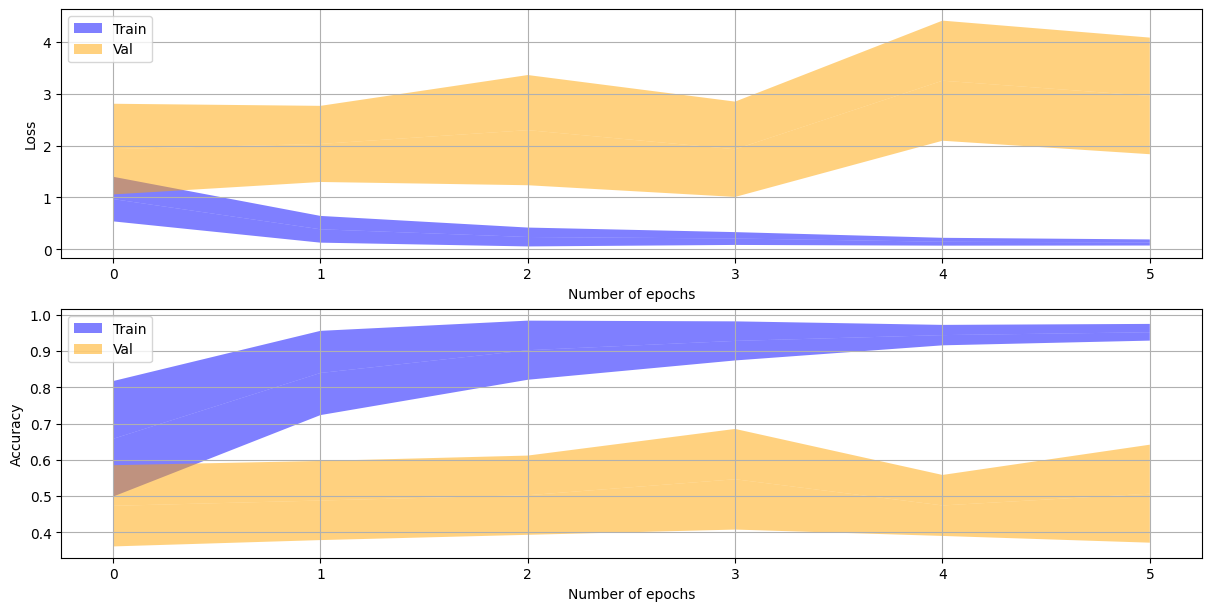

In [17]:
import matplotlib.pyplot as pl

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

## Evaluate model on test set

In [18]:
# First retrain model on all the training data
train_images = open_images(total_train_paths)    
train_labels = total_train_labels

model = get_model() # We reinitialize the model

history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=16,
    epochs=NB_EPOCHS,
)

Epoch 1/6
60/60 [==============================] - 45s 593ms/step - loss: 0.2876 - acc: 0.9005
Epoch 2/6
60/60 [==============================] - 36s 592ms/step - loss: 0.1439 - acc: 0.9529
Epoch 3/6
60/60 [==============================] - 35s 590ms/step - loss: 0.0813 - acc: 0.9707
Epoch 4/6
60/60 [==============================] - 35s 588ms/step - loss: 0.0943 - acc: 0.9696
Epoch 5/6
60/60 [==============================] - 35s 589ms/step - loss: 0.0632 - acc: 0.9791
Epoch 6/6
60/60 [==============================] - 36s 606ms/step - loss: 0.1081 - acc: 0.9696


In [19]:
# Empty a bit the memory
import gc

del train_images
del train_labels
gc.collect()

11467

In [20]:
import sklearn.metrics as me
test_images = open_images(test_paths)    

pred = model.predict(test_images)
pred = np.argmax(pred, axis=-1)

test_confusion_matrix = me.confusion_matrix(test_labels, pred, labels=np.arange(len(QUERIES)))

8/8 [==============================] - 3s 244ms/step


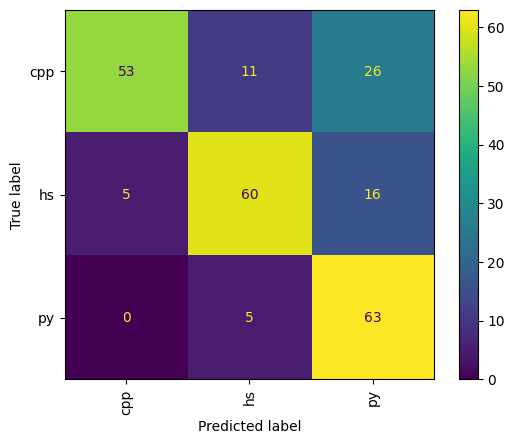

In [21]:
confusion_matrix_display = me.ConfusionMatrixDisplay(
    confusion_matrix=test_confusion_matrix,
    display_labels=QUERIES,
)

confusion_matrix_display.plot(xticks_rotation='vertical')
plt.show()

# GRAD-CAM HEATMAP

In [22]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    # as well as the output predictions
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    # Compute the gradient of the top predicted class for the input image
    # with respect to the activations of the last conv layer
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Pool the gradients over all the axes
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weigh the output feature map of the last conv layer with the pooled gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Apply ReLU to the heatmap (eliminate negative values)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

def display_heatmap(ax, img, heatmap, alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")
    
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Create an image with RGB colorized heatmap
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize(img.size)  # Use img.size instead of img.shape
    jet_heatmap = image.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)
    
    # Display the superimposed image on the given axes
    ax.imshow(superimposed_img)
    ax.axis('off')


AttributeError: module 'matplotlib.cm' has no attribute 'get_cmap'

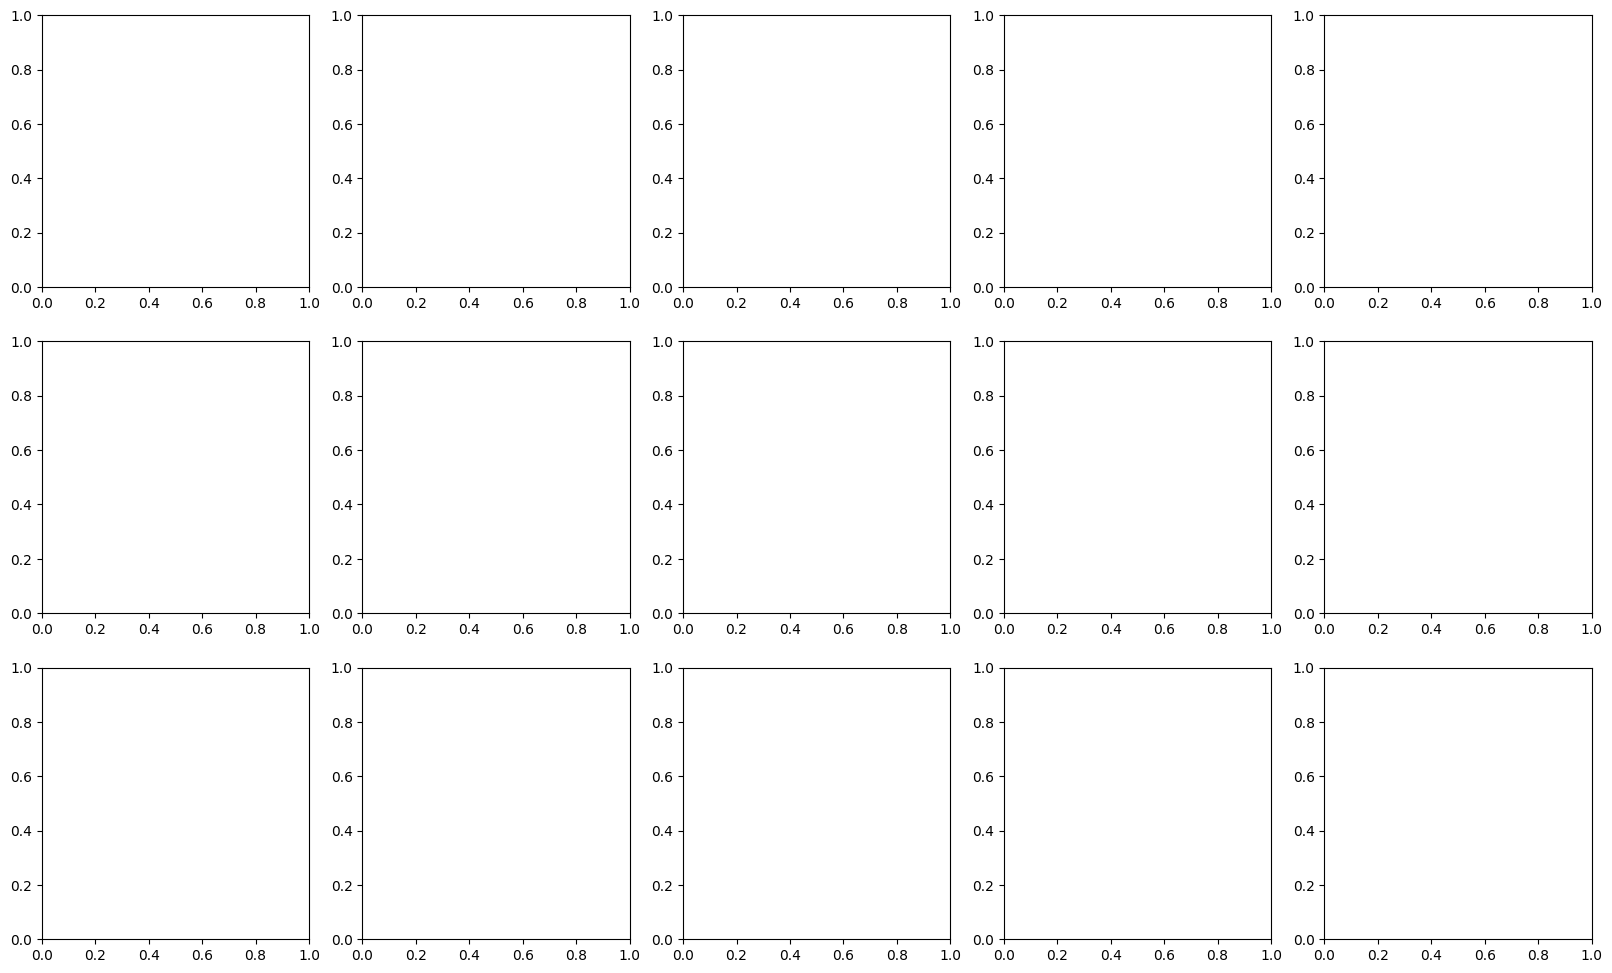

In [23]:
import os
import random
# Update these paths based on your directory structure
base_dir = 'raw_data/img/ready'

# Get the current working directory
script_dir = os.getcwd()

# Classes and their prefixes
classes = {
    "cpp": "cpp",
    "hs": "hs",
    "py": "py"
}

# Number of images per class
num_images_per_class = 5

# Dictionary to hold selected images for each class
selected_images = {cls: [] for cls in classes}

# Randomly select 5 images for each class
for cls, prefix in classes.items():
    all_images = [file for file in os.listdir(base_dir) if file.startswith(prefix) and file.endswith('.png')]
    selected_images[cls] = random.sample(all_images, num_images_per_class)

# Create a figure for displaying the images and heatmaps
fig, axes = plt.subplots(3, 5, figsize=(20, 12))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Counter to keep track of the subplot index
ax_idx = 0

# Display images and heatmaps
for cls, images in selected_images.items():
    for img_file in images:
        img_path = os.path.join(script_dir, base_dir, img_file)
        
        # Preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Generate heatmap
        last_conv_layer_name = "Conv_1_bn"  # This may change based on your model architecture
        heatmap = get_gradcam_heatmap(img_array, model, last_conv_layer_name)

        # Display image and heatmap
        display_heatmap(axes[ax_idx], img, heatmap)
        ax_idx += 1

plt.tight_layout()
plt.show()

In [24]:
import tensorflow as tf
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

# Task Library expects label files that are in the same format as the one below.
LABEL_FILE = "labels.txt"
SAVE_TO_PATH = "MyModel.tflite"

# Create the labels file
with open(LABEL_FILE, 'w') as label_file:
    for label in classes: # /!\ class_names variable must contains the names of the labels you have.
        label_file.write("{}\n".format(label))

tflite_model = tf.lite.TFLiteConverter.from_keras_model(model).convert()

# Save the model.
with open(SAVE_TO_PATH, 'wb') as f:
    f.write(tflite_model)
    
ImageClassifierWriter = image_classifier.MetadataWriter

# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/convert/metadata#normalization_and_quantization_parameters)
INPUT_NORM_MEAN = 127.5
INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(SAVE_TO_PATH),
    [INPUT_NORM_MEAN],
    [INPUT_NORM_STD],
    [LABEL_FILE]
)

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), SAVE_TO_PATH)

INFO:tensorflow:Assets written to: C:\Users\Anthony\AppData\Local\Temp\tmp220h7inz\assets


INFO:tensorflow:Assets written to: C:\Users\Anthony\AppData\Local\Temp\tmp220h7inz\assets


{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba